# Quantitative exercise - Group 28 Kim Hammar (kimham@kth.se) & Konstantin Sozinov (sozinov@kth.se)

## Imports

In [29]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
from sklearn import linear_model
from sklearn import neural_network
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

FEATURE_NAMES = ['rttMean', 'rttStd', 'rttMin', 'rttMax', 'geo', 'bandwidth', 'noCrashes', 'rtt']

We are going to use pandas, numpy and scipy as statistical tools.

For our research project we will use similar tools as in this notebook, but also more machine learning libraries.

## Get Data

In [25]:
data = pd.read_csv('rtt_data.csv')

df = data.drop(['node', 'timestamp'],axis=1)

df.describe()

,rttMean,rttStd,geo,rttMin,rttMax,bandwidth,rtt
count,14260.000000,14260.000000,14260.000000,14260.000000,14260.000000,14260.000000,14260.000000
mean,6629.300190,922.386336,2.953366,5271.755680,9436.077910,16.867391,6631.231978
std,24278.747497,675.795476,2.661937,24078.677687,24240.026555,7.694297,24283.494512
min,81.000000,6.500000,0.000000,0.000000,206.000000,0.000000,0.000000
25%,457.621212,371.541036,1.000000,1.000000,2250.000000,11.000000,181.000000
50%,1370.803030,598.645572,3.000000,1.000000,3939.000000,17.000000,1250.000000
75%,3244.714646,1450.101921,4.000000,971.000000,7131.000000,23.000000,3361.000000
max,345630.000000,5043.160473,19.000000,345630.000000,347021.000000,29.000000,347021.000000


This table shows some statistical information about the data such as mean, std and different quintiles. Our RTT features are statistical measurments (in ms) from previous Round-Trip Time (RTT) measurments from different nodes from the distributed systems. Geo location and bandwidth are artificial constants. 

Expected properties:
1. All features are positive.
2. RTT cannot be higher than 2 min (1200000 ms).
3. One node should have same geo location and same bandwidth during the simulation, i.e. we shoud have 20 different geo locations and 30 different bandwidth scores.

From describe we see that all fetures are positive.

## Verify expected properties

Check point 3 from the expected properites

In [11]:
grouped_geo = data.groupby(['geo']).count()

grouped_geo

,node,rttMean,rttStd,rttMin,rttMax,bandwidth,rtt,timestamp
geo,,,,,,,,
0.0,1732,1732,1732,1732,1732,1732,1732,1732
1.0,2901,2901,2901,2901,2901,2901,2901,2901
2.0,2354,2354,2354,2354,2354,2354,2354,2354
3.0,2984,2984,2984,2984,2984,2984,2984,2984
4.0,1809,1809,1809,1809,1809,1809,1809,1809
5.0,857,857,857,857,857,857,857,857
6.0,417,417,417,417,417,417,417,417
7.0,424,424,424,424,424,424,424,424
8.0,193,193,193,193,193,193,193,193


We have 20 different geo locations which is correct.

In [12]:
grouped_bw = data.groupby(['bandwidth']).count()

grouped_bw

,node,rttMean,rttStd,geo,rttMin,rttMax,rtt,timestamp
bandwidth,,,,,,,,
0.0,11,11,11,11,11,11,11,11
1.0,156,156,156,156,156,156,156,156
2.0,338,338,338,338,338,338,338,338
3.0,227,227,227,227,227,227,227,227
4.0,67,67,67,67,67,67,67,67
5.0,62,62,62,62,62,62,62,62
6.0,1045,1045,1045,1045,1045,1045,1045,1045
7.0,17,17,17,17,17,17,17,17
8.0,190,190,190,190,190,190,190,190


We have 30 different bandwidth scores which is correct.

In [15]:
rtt_data = data['rtt'].max()
rtt_data / 60000


5.7836833333333333

Here the expected property are not correct, we will revise our simulations.

## Data exploration

In [27]:
def plot_two_features(df, feature_1, feature_2, text_for_feature_1, text_for_feature_2, title):
    plt.scatter(df[feature_1],df[feature_2], c = "black", marker = "x")
    plt.title(title)
    plt.xlabel(text_for_feature_1)
    plt.ylabel(text_for_feature_2)
    plt.show()

### RTT Geo location correlation

Our assumption here that RTT should grow once distance between two nodes grows, i.e. RTT depends on Geo location.

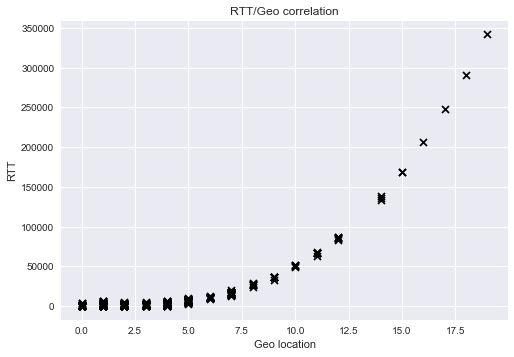

In [28]:
geo_rtt = df[['geo', 'rtt']].sample(frac=0.05)
plot_two_features(geo_rtt, 'geo', 'rtt', 'Geo location', 'RTT', 'RTT/Geo correlation')

This grap shows that RTT grows exponentially when the distance between two nodes grows. 

### Bandwidth and RTT

It is expected that the higher bandwidth value the lower RTT, but as we can in the plot this is not exactly the case. This is beacause the geo location have more influence on the RTT value than bandwidth

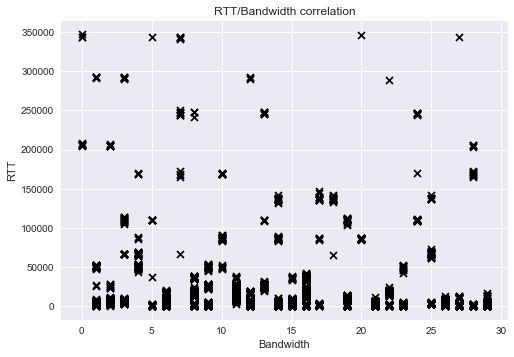

In [29]:
bandwidth_rtt = df[['bandwidth', 'rtt']]
plot_two_features(bandwidth_rtt, 'bandwidth', 'rtt', 'Bandwidth', 'RTT', 'RTT/Bandwidth correlation')

### Covariance matrix

This will show how dependent are features on each other. As expected we have strong correleation between all RTT features since they were derived from the RTT itself.

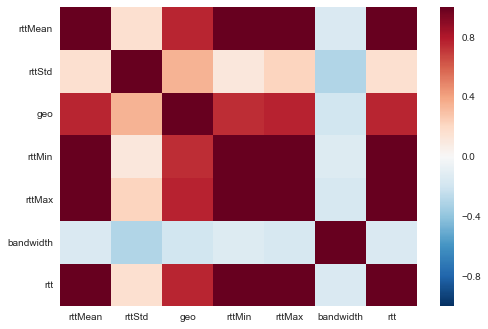

In [30]:
corr = df.corr()
sns.heatmap(corr)
plt.show()

## Fit the data to a model

Fit the relation between independent variable location and dependent variable RTT to linear regression model

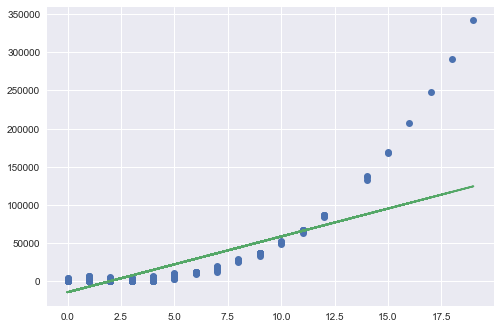

In [32]:
x = geo_rtt['geo']
y = geo_rtt['rtt']

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

line = slope * x + intercept

plt.plot(x,y ,'o', x, line)
plt.show()

We expected a linear relationship, but the relationship between the data is exponetial. 